Sometimes when in learning data science and Machine Learning we use cleaned and nice dataset to perform the task. But in real life it is difficult to have a cleaned and ready-to-apply dataset.  
But this shouldn't stop you from pursuing your task.  
Data can be missing for many different reasons; however, these reasons are usually lumped into two categories: informative missingess (Kuhn and Johnson 2013) and missingness at random (Little and Rubin 2014).  
  
    
In this tutorial I want to show you some techniques I've recently learned to impute missing values.  
I will be using the `Ames Housing` data set to present you these techniques. You can find this dataset on [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) or in the {AmesHousing} R package.

In [25]:
#Let's read the dataset and load the packages we'll need
options(warn = -1)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(recipes))
suppressPackageStartupMessages(library(caret)) # preprocessing tools
ames <- AmesHousing::ames_raw # the dataset

# Visualizing missing data

The first thing we need to know is to understand the distribution of missingness in the dataset. A simple but effective way is to plot the missing data. Let's use {ggplot2} to visualize the data

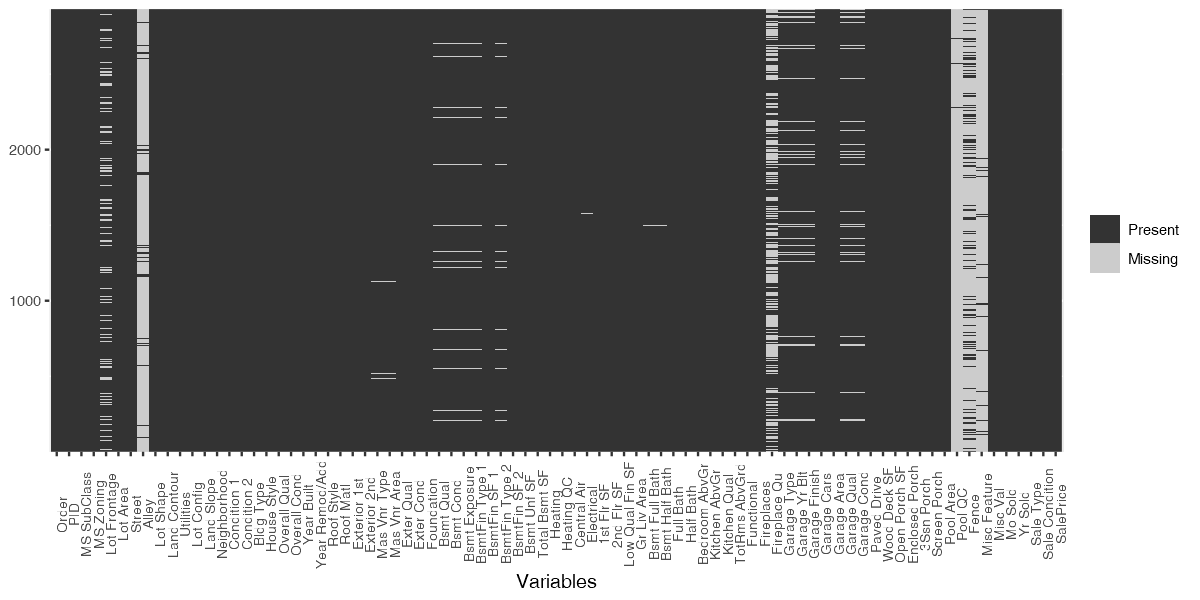

In [2]:
options(repr.plot.width = 10, repr.plot.height = 5) # plot settings

ames %>% is.na () %>% reshape2::melt() %>%
ggplot(aes(x = Var2, y = Var1, fill = value)) +
geom_raster() + 
scale_fill_grey(name = "", labels = c("Present", "Missing")) +
scale_y_continuous(NULL, expand = c(0, 0)) +
theme(axis.text.x = element_text(angle = 90, size = 8)) + 
labs(x = "Variables")

You can use other packages such as `Amelia::missmap()` to do this kind of plot or simply use the `visdat::vis_miss()` as shown below.

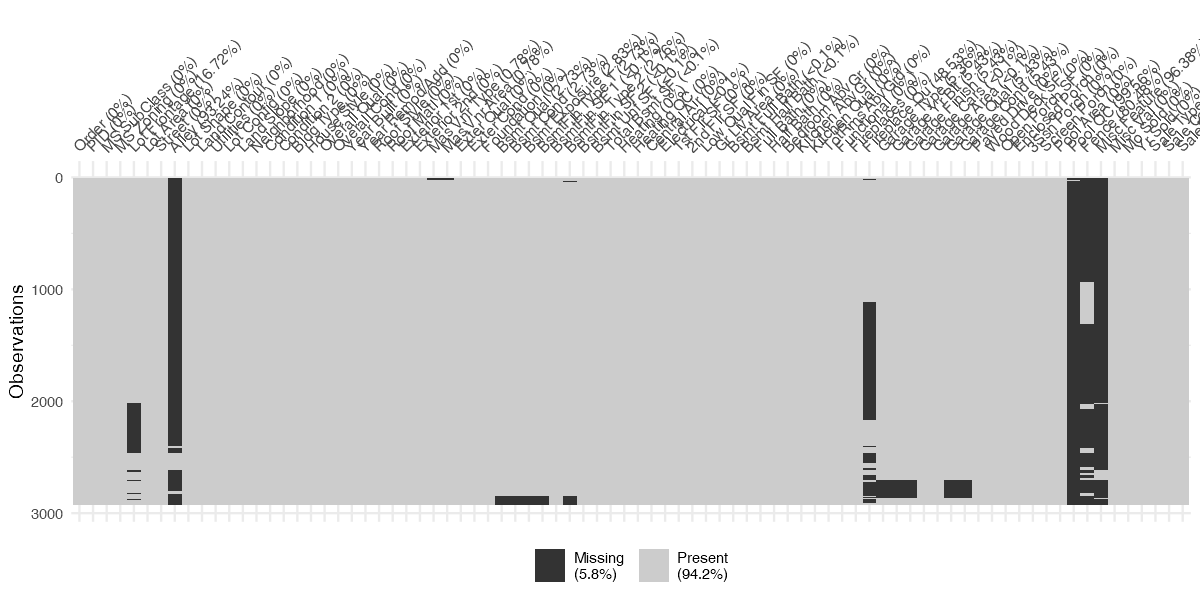

In [3]:
visdat::vis_miss(ames, cluster = T)

This second option takes more time to compute.  
# Imputation techniques
In a dataset we have either numerical columns (which can be ordinal or continuous) and categorical columns.  

## Imputing numerical columns
I think imputing continuous columns is the easiest to implement. Some algorithms such as PCA impute missing values by the mean value of the column, some people prefer to use the median. To demonstrate the efficiency of these techniques I will use the `Sale_Price` column of the Ames Housing dataset of which I will randomly remove some values

In [2]:
sum(is.na(ames$SalePrice))

[1] 0

In [26]:
# Let's randomly remove some values
set.seed(123) # for reproducibility
idx <- sample(1:nrow(ames), size = 200) # random index
ames <- ames %>% mutate(SalePrice2 = SalePrice, 
                        missing_sp = SalePrice)
ames$SalePrice2[idx] <- NA
ames$missing_sp[-idx] <- NA

In [27]:
sum(is.na(ames$SalePrice2))

[1] 200

Here's how the SalePrice column is affected with the missing values

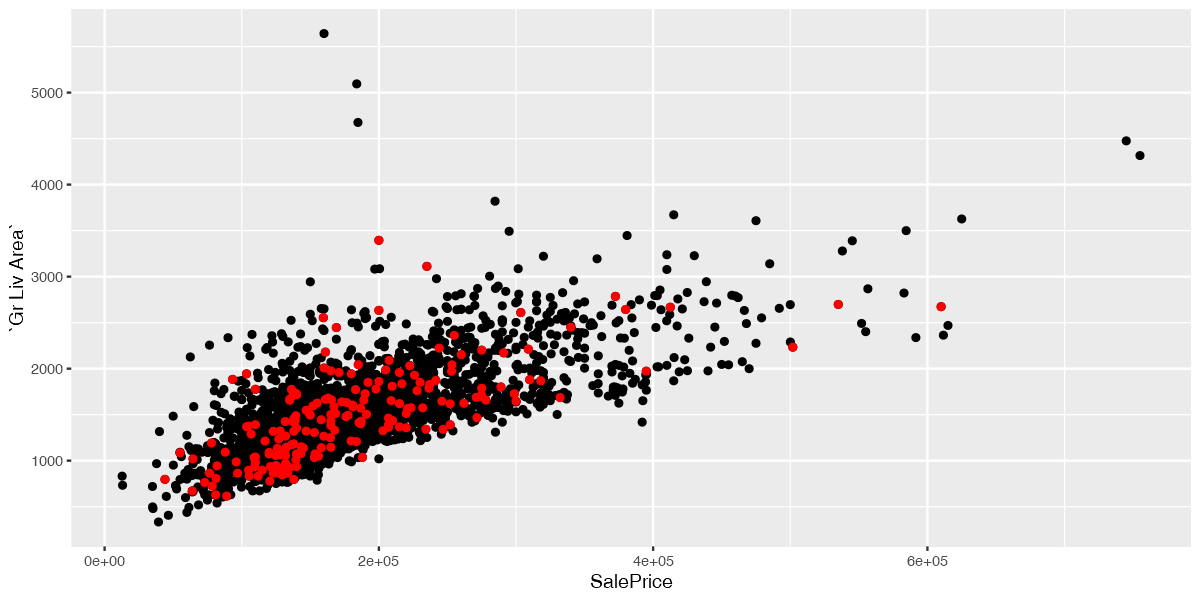

In [7]:
ames %>%
ggplot(aes(x = SalePrice, y = `Gr Liv Area`)) +
geom_point() + 
geom_point(aes( x = missing_sp, y = `Gr Liv Area`), col = "red")

In black are the values present in the dataset and in red are the removed values. Keep this plot in mind as a reference to judge the quality of the imputation

# Comparing different imputation techniques

In [28]:
ames <- ames %>%
mutate(mean_sp_imputation = SalePrice2,
      median_sp_imputation = SalePrice2,
      knn_sp_imputation = SalePrice2,
      bag_sp_imputation = SalePrice)

I'm going to use the amazing {recipes} package to `order` different imputations for the columns I just created.

In [29]:
rec <- recipe(SalePrice~., data = ames) %>%
step_meanimpute(mean_sp_imputation) %>%
step_medianimpute(median_sp_imputation) %>%
step_knnimpute(knn_sp_imputation) %>%
step_bagimpute(bag_sp_imputation)

In [30]:
# Let's display what is in this recipe object
rec

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         87

Operations:

Mean Imputation for mean_sp_imputation
Median Imputation for median_sp_imputation
5-nearest neighbor imputation for knn_sp_imputation
Bagged tree imputation for bag_sp_imputation

This object is basically a recipe for what we want to do with the data.  
Let's now transform the data

In [31]:
rec <- prep(rec, training = ames, retain = T)

In [32]:
cleaned <- rec$template

In [46]:
theme_set(theme_bw())

In [47]:
cleaned$mean_sp_imputation[-idx] <- NA
cleaned$median_sp_imputation[-idx] <- NA
cleaned$knn_sp_imputation[-idx] <- NA
cleaned$bag_sp_imputation[-idx] <- NA

#missing values
missing <- cleaned %>% ggplot() + 
geom_point(aes( x = missing_sp, y = `Gr Liv Area`), col = "red") +
labs(title = "Missing values")

## Mean imputation
mean_imputation <- cleaned %>% 
ggplot() + geom_point(aes( x = mean_sp_imputation , y = `Gr Liv Area`), col = "blue") +
labs(title = "Mean Imputation")

# Median imputation
median_imputation <- cleaned %>% 
ggplot() + geom_point(aes( x = median_sp_imputation , y = `Gr Liv Area`), col = "blue") +
labs(title = "Median imputation")

# Knn imputation
knn_imputation <- cleaned %>% 
ggplot() + geom_point(aes( x = knn_sp_imputation , y = `Gr Liv Area`), col = "blue") +
labs(title = "Knn imputation")

# Bagged tree imputation
bag_imputation <- cleaned %>% 
ggplot() + geom_point(aes( x = bag_sp_imputation , y = `Gr Liv Area`), col = "blue") +
labs(title = "Bagged tree imputation")

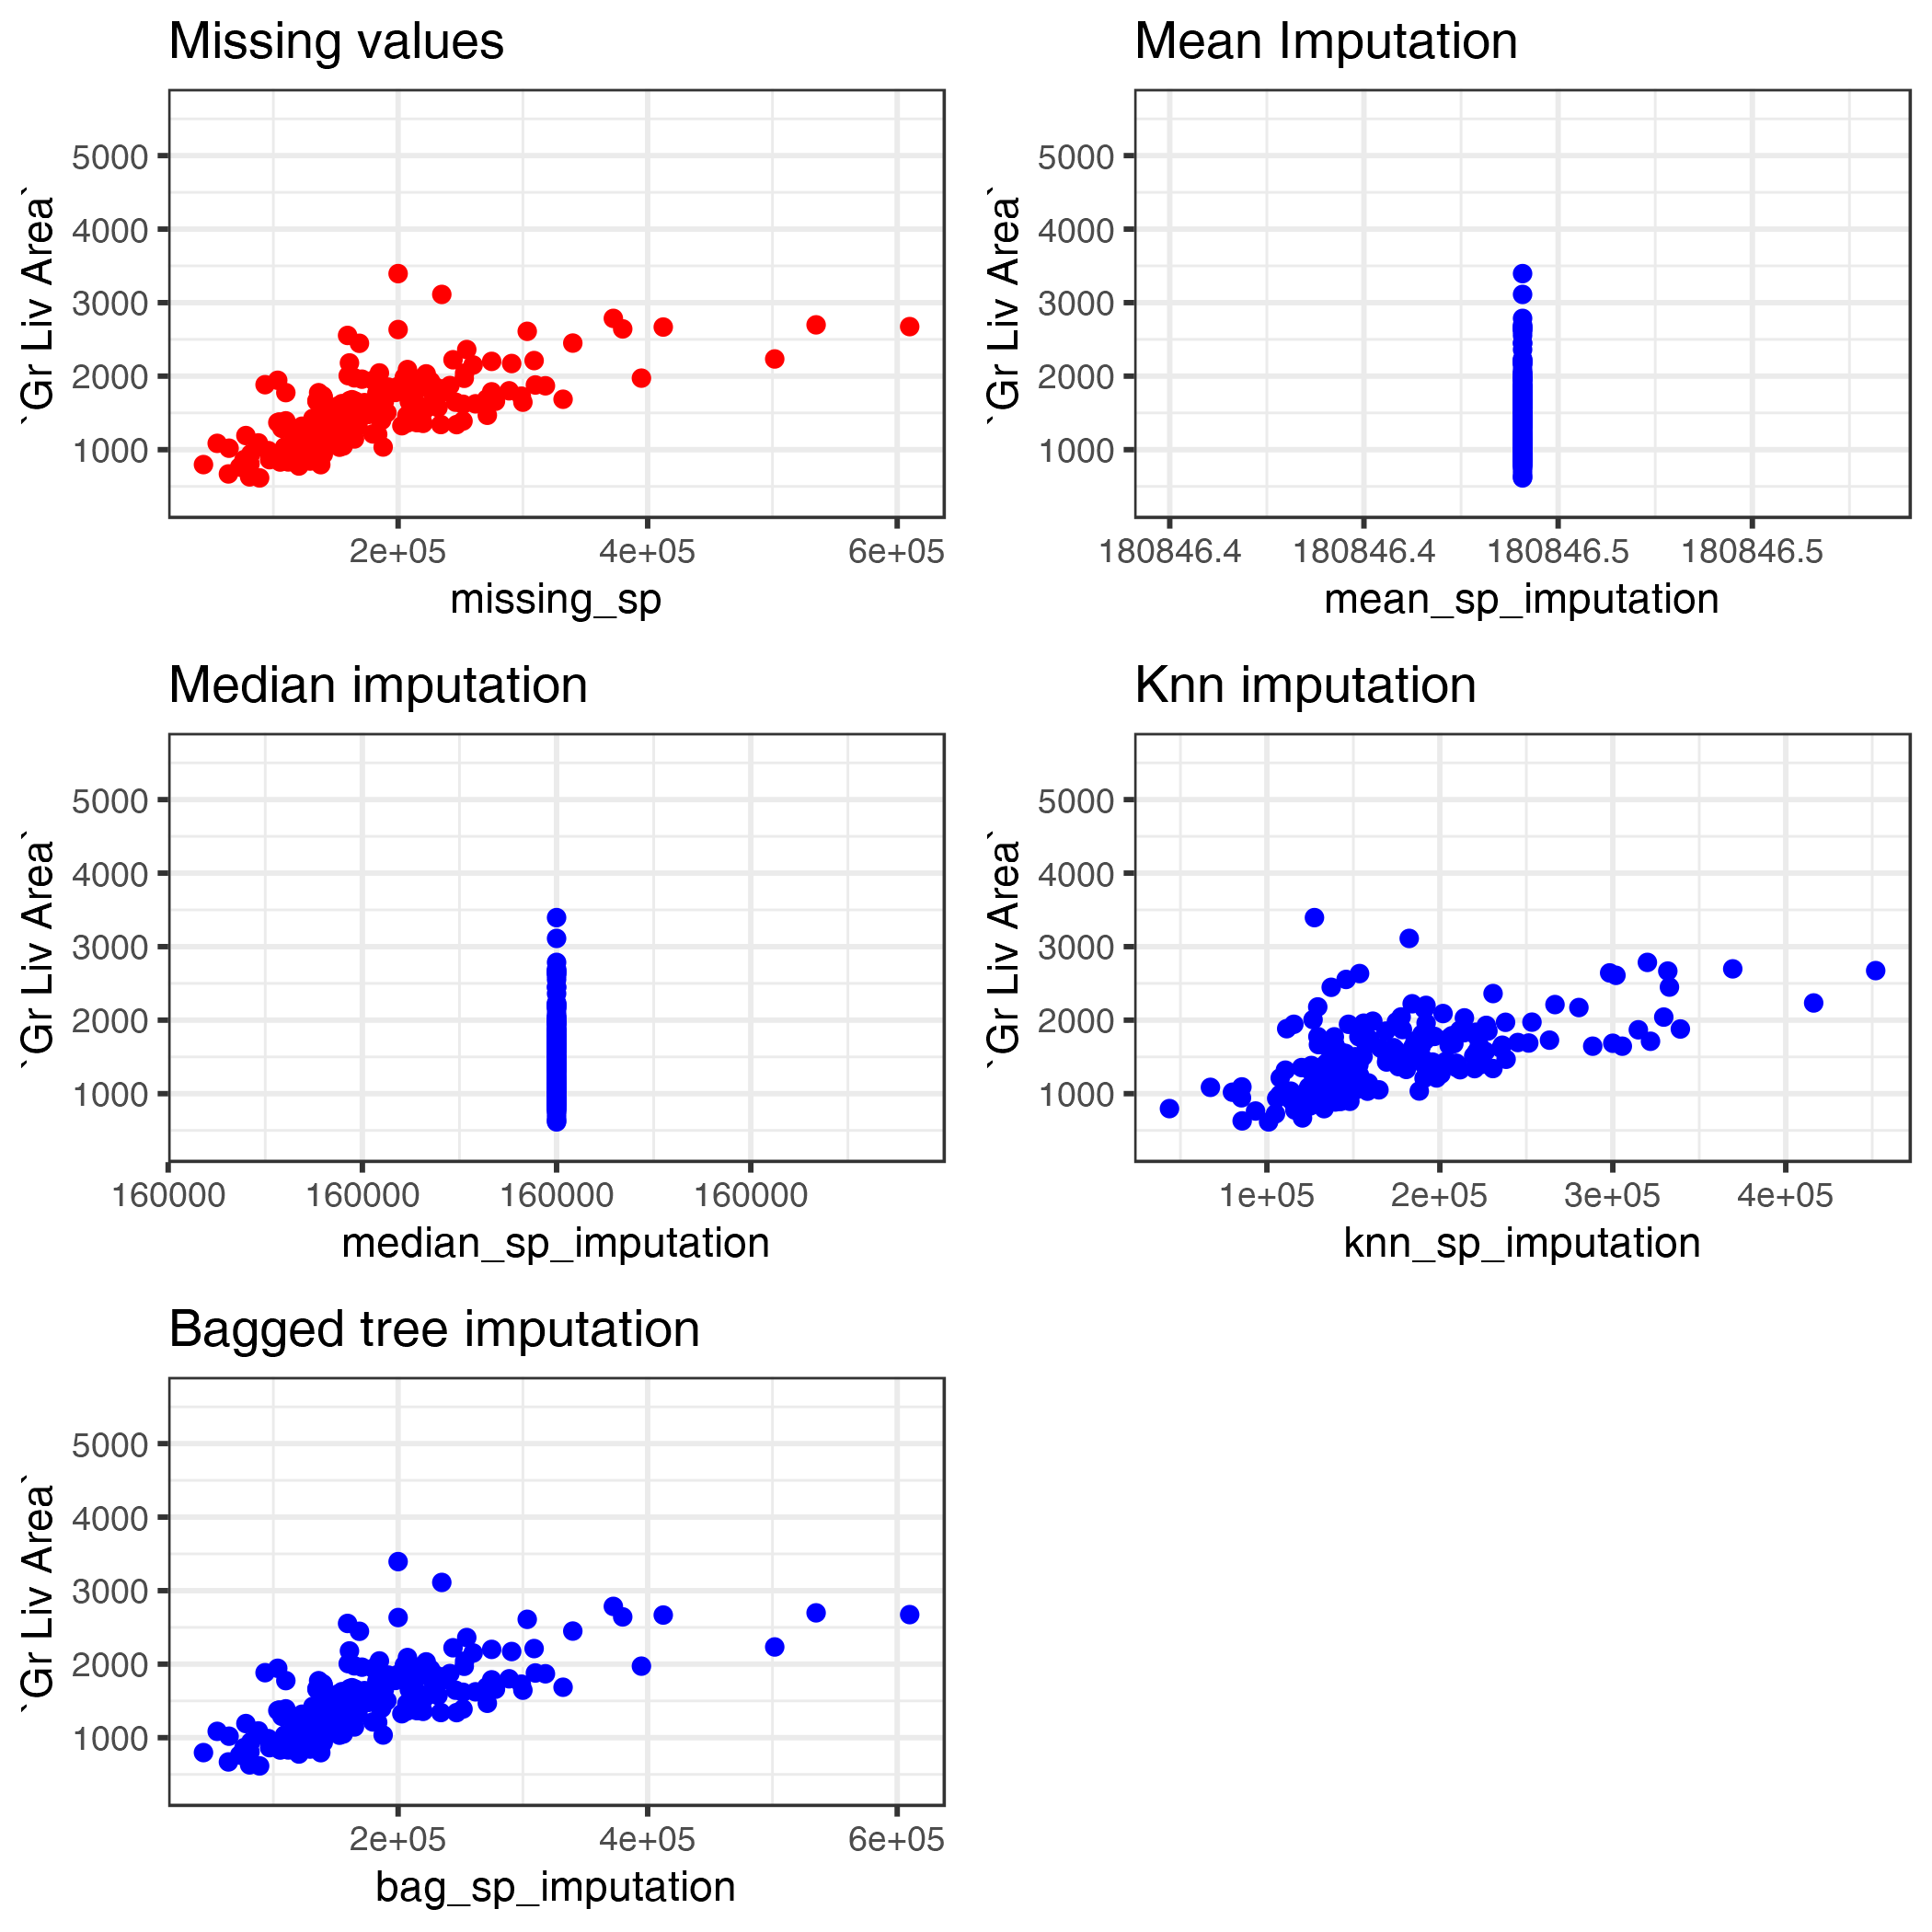

In [48]:
options(repr.plot.res = 300)
cowplot::plot_grid(missing, mean_imputation, median_imputation, 
                  knn_imputation, bag_imputation, ncol = 2)

# Conclusion

As we can see on these plots, imputing missing values with the mean or median is not a really good idea because the imputed values completely ignores the distribution of the column.  
Doing so can affect the performance of the model.  

The recipes package made it very easy to impute those missing value without even the need to load a specific package for the task. This is absolutely great !  

**Feel free to comment, I'm always glad to receive feedbacks and improvements are always welcome!**

# References :
For this blog post I took inspiration from the chapter 3 of the *Hands-on Machine Learning with R* book by
**Brad Boehmke** & **Brandon Greenwell**.  
You can read the book for free at : https://bradleyboehmke.github.io/HOML/engineering.html